## Image-to-image Style Transfer

In [7]:
# The notebook ran on a free-T4 instance on Google Colab

# !pip install -q diffusers transformers torch Pillow

In [8]:
import torch
import numpy as np
import requests
import io
from transformers import pipeline
from diffusers.utils import make_image_grid
from PIL import ImageFile, Image

ImageFile.LOAD_TRUNCATED_IMAGES = True

def fetch_url_as_image(url):
    # Fetch the image content using requests and ensure it is fully loaded.
    # Adding a User-Agent header to the request
    headers = {
        # Replace with your bot's name and contact information
        "User-Agent": "MyBot/1.0 (your_email@example.com)"
    }
    response = requests.get(url, stream=True, headers=headers)
    response.raise_for_status()
    image_content = response.content

    # Open the image using io.BytesIO to provide a file-like object to PIL.Image.open
    image = Image.open(io.BytesIO(image_content))
    # reduce the size of the image by 75%
    image = image.resize((image.width // 4, image.height // 4))
    return image

wanderer_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Caspar_David_Friedrich_-_Wanderer_above_the_sea_of_fog.jpg/800px-Caspar_David_Friedrich_-_Wanderer_above_the_sea_of_fog.jpg"
wanderer_image = fetch_url_as_image(wanderer_url)

def get_depth_map(image, depth_estimator):
    depth_image = depth_estimator(image)["depth"]
    image = np.array(depth_image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    depth_map = detected_map.permute(2, 0, 1)
    return depth_image, depth_map.unsqueeze(0).half().to("cuda")

depth_estimator = pipeline("depth-estimation")
wanderer_depth_image, wanderer_depth_map = get_depth_map(wanderer_image, depth_estimator)

No model was supplied, defaulted to Intel/dpt-large and revision bc15f29 (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


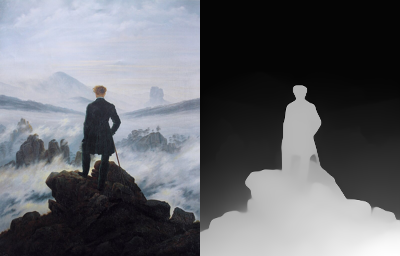

In [9]:
make_image_grid([wanderer_image, wanderer_depth_image], rows=1, cols=2)

In [10]:
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16, use_safetensors=True)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


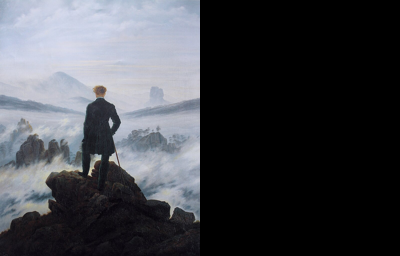

In [11]:

# Additional parameters for the image generation:
# 1. strength (float, 0-1):
#    - Controls how much to transform the reference image
#    - Lower values preserve more of the original image
#    - Higher values allow more variation

# 2. guidance_scale (float, usually 1-20):
#    - Controls how closely the image follows the prompt
#    - Higher values = more prompt adherence
#    - Lower values = more creative freedom

# 3. num_inference_steps (int):
#    - More steps = potentially better quality but slower
#    - Typical values: 30-100

output = pipe(
    "Star Wars' Darth Vader with a red light saber",
    image=wanderer_image,
    control_image=wanderer_depth_map,
    strength=0.5,
    guidance_scale=7.5,
    num_inference_steps=100,
).images[0]
make_image_grid([wanderer_image, output], rows=1, cols=2)